## Core

- Measure fluxes from a region at multiple frequencies



In [30]:
import numpy as np
from astropy.io import ascii, fits
import fluxInt
import pbCorr
import synCl
import convRegr
from prettytable import PrettyTable
import shutil,os, string
import fitSource

from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator
import matplotlib.ticker
from matplotlib import transforms as mtransforms

C = 2.99792458e8

ftSrc = fitSource.fitSrc()
fint = fluxInt.flInt()

#rootdir
#rootDir = '/Users/maccagni/Projects/MFS/FornaxA/contData/kore/'
rootDir = '/home/maccagni/Projects/MFS/FornaxA/contData/core/'

#label

aut='F8'

subRegions = ['cjet/','centre/','jet/']
labelReg = ['cjFine','cFine','jFine']
jCount = [8,5,7]

imDir = rootDir+'inIms/'
fint.rootdir = imDir

regDir = imDir+'inReg/'
outTabs = rootDir+'outTabs/'
figDir = rootDir+'coreFigs/'

#input image
inIm = imDir+'Meer_1440MHz_pbcorr_cutCtr.fits'
noise = 0.
errFlux = 15.

#output table 
labelDim = ['1D','2D']
outTables = [outTabs+'jCjFluxWidth'+labelDim[0]+'.tbl',outTabs+'jCjFluxWidth'+labelDim[1]+'.tbl']

beta = 0.2
alpha =0.7
print alpha
#-------------------------------------------------#
# Jet and counter-jet flux ratio
#-------------------------------------------------#
def splitter(A):
    B = A[0:len(A)//2]
    C = A[len(A)//2:]

    return (B,C)


print '''\t+---------+\n\t Inputs loaded\n\t+---------+'''


0.7
	+---------+
	 Inputs loaded
	+---------+


In [31]:
#-------------------------------------------------#
# Jet and counter-jet analysis
#-------------------------------------------------#

datas,heads = fint.openFile(inIm)
#Regions where to measure flux
for i in xrange(0,len(labelDim)):
    if os.path.exists(outTables[i]):
        os.remove(outTables[i])

fr=[]
flIntBeamArray=[]
flErrBeamArray=[]
flIntOutArray=[]
flErrOutArray=[]

for i in xrange(0,len(subRegions)):
    for j in xrange(0,jCount[i]):
        dd = datas.copy()
        
        region = regDir+subRegions[i]+labelReg[i]+str(j)+'.reg'

        maskedData, background, rms, pixels=fint.maskDatReg(dd,heads,region,noise)
        
        fits.writeto(rootDir+str(i)+'_mask_jCj.fits',maskedData,heads,overwrite=True)

        maskedData[maskedData==0.0] = np.nan

        fluxint, numPixBeam =fint.measFlux(maskedData,heads,errFlux,'none')
        peakIm = np.nanmax(maskedData)
        
        maskedData[np.isnan(maskedData)] = 0.0
        
        params2D = ftSrc.gaus2Dfit(maskedData)
        
        compressedData = np.sum(maskedData,axis=1)
                
        params1D = ftSrc.gaus1Dfit(compressedData)
        
        params2D = np.insert(params2D,0,fluxint)
        params2D = np.insert(params2D,0,peakIm)

        params1D = np.insert(params1D,0,fluxint)
        params1D = np.insert(params1D,0,peakIm)

        
        regionName =  string.split(region,'/')[-1]
        
    
        for k in xrange(0,len(labelDim)):
            if k==0:
                t = ftSrc.writeGaus1DfitTable(regionName,outTables[k],params1D)
            elif k==1:
                t = ftSrc.writeGaus2DfitTable(regionName,outTables[k],params2D)
                
widthBeam = heads['BMAJ']*3600.     
for i in xrange(0,len(labelDim)):
    
    table= ascii.read(outTables[i])
    #define parameters
    width = table['width X']*2.355*heads['CDELT2']*3600. #from sigma in pix to fwhm in arcsec. 
    widthReal = width.copy()
    for j in xrange(0,len(width)):
        if width[j]>=widthBeam:
            widthReal[j] = np.sqrt(np.power(width[j],2)-np.power(widthBeam,2))
        else:
            widthReal[j] = widthBeam
    
    surfBright = table['PeakIm']*np.sqrt((np.power(widthReal,2)/np.power(widthBeam,2)+1))
    
    
    table.add_column(surfBright, name='surfaceBrightness')
    table.add_column(widthReal, name='deconvolvedWidth')
    
    ascii.write(table,outTables[i], overwrite=True)

    #for k in xrange(0,len(labelDim)):
    #    if k==0:
    #       t = ftSrc.writeGaus1DfitTable(regionName,outTables[k],params1D)
    #    elif k==1:
    #        t = ftSrc.writeGaus2DfitTable(regionName,outTables[k],params2D)
        
        
print '''\t+---------+\n\t Flux & size variation along jet\n\t+---------+'''
  

	+---------+
	 Flux & size variation along jet
	+---------+


In [40]:
def jCjPlot(radius,brightJet, brightCJet,sizeJet,sizeCJet,ratio,width,m,b,outfile):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize=(20,20),constrained_layout=True,)

    #fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(2, 2)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_xlabel(r'distance from core [arcsec]')
    ax1.set_ylabel(r'$I$ [Jy beam$^{-1}$]')
    #ax1.set_yscale("log", nonposy='clip')
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(axis='both', which='major', pad=5)

    ax1.plot(radius,brightJet,lw=3, marker='o', color='blue', linestyle=' ',label='jet',alpha=1)
    ax1.plot(radius,brightCJet,lw=3, marker='o', color='red', linestyle=' ',label='counter-jet',alpha=1)

    ax1.legend = plt.legend(loc=1, prop={'size': 20})
    ax1.legend.get_frame().set_edgecolor('black')


    ax2 = fig.add_subplot(gs[0,1])
    
    ax2.set_xlabel(r'distance from core [arcsec]')
    ax2.set_ylabel(r'$w$ [arcsec]')
    #ax2.set_yscale("log", nonposy='clip')

    ax2.tick_params(axis='both', which='major', pad=5)
    ax2.xaxis.set_minor_locator(AutoMinorLocator())

    ax2.plot(radius,sizeJet,lw=3, marker='o', color='blue', linestyle=' ',label='jet',alpha=1)
    
    ax2.plot(radius,sizeCJet,lw=3, marker='o', color='red', linestyle=' ',label='counter-jet',alpha=1)

    ax2.legend = plt.legend(loc=2, prop={'size': 20})
    ax2.legend.get_frame().set_edgecolor('black')
    
    ax3 = fig.add_subplot(gs[1,0])
    ax3.set_xlabel(r'distance from core [arcsec]')
    ax3.set_ylabel(r'$I_{\rm j}/I_{\rm cj}$')
    #ax3.set_yscale("log", nonposy='clip')
    ax3.xaxis.set_minor_locator(AutoMinorLocator())
    
    ax3.tick_params(axis='both', which='major', pad=5)
    ax3.plot(radius,ratio,lw=3, marker='o', color='black', linestyle=' ',label='',alpha=1)  

    #ax3.legend = plt.legend(loc=1, prop={'size': 30})
    
    # Initialize subplots
    ax4 = fig.add_subplot(gs[1,1])
    ax4.xaxis.set_minor_locator(AutoMinorLocator())
    
    ax4.set_ylabel(r'$I$ [Jy beam$^{-1}$]')
    ax4.set_xlabel(r'$w$ [arcsec]')
    #ax4.set_xscale("log")
    #ax4.set_yscale("log")
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    #ax4.set_xlim([-0.5,1.5])
    #ax4.set_ylim([1e-2,1])
    #ax4.set_xticks([2,5,10,20,30,40])
    #ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax4.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())   
    
    #ax4.set_yticks([1e-2,2e-2,1e-1])
    #ax4.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax4.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())   
    
    ax4.tick_params(axis='both', which='major', pad=5)
    #ax4.plot(ratio[0:],width[0:],lw=3, marker='o', color='black', linestyle=' ',label='',
    #         alpha=1)
    ax4.plot(sizeJet,brightJet,lw=3,marker='o',color='blue',linestyle=' ',label='jet', alpha=1)
    ax4.plot(sizeCJet,brightCJet,lw=3,marker='o',color='red',linestyle=' ',label='counter-jet', alpha=1)
    
    xmin = np.nanmin(sizeJet)
    xmax = np.nanmax(sizeCJet)
    x = np.linspace(xmin,xmax,1e3)
    A = .2
    y = A*np.power(x,-3./4.)
    
    ax4.plot(x,y,lw=2,marker=' ',color='black',linestyle='--',label='model', alpha=1)
   
    yy = -b*np.power(x,m)
        
    #ax4.plot(x,yy,lw=2,marker=' ',color='black',linestyle='-.',label='fit', alpha=1)

    ax4.legend = plt.legend(loc=1, prop={'size': 20})
    
    # Save figure to file
    plt.savefig(outfile,overwrite = True)



16.681799278742126 22.56593863377832
0.05008932412314844 0.03298573074587697
Jets opening angle
-1.9999195158112058


/home/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in arccos
/home/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:110: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


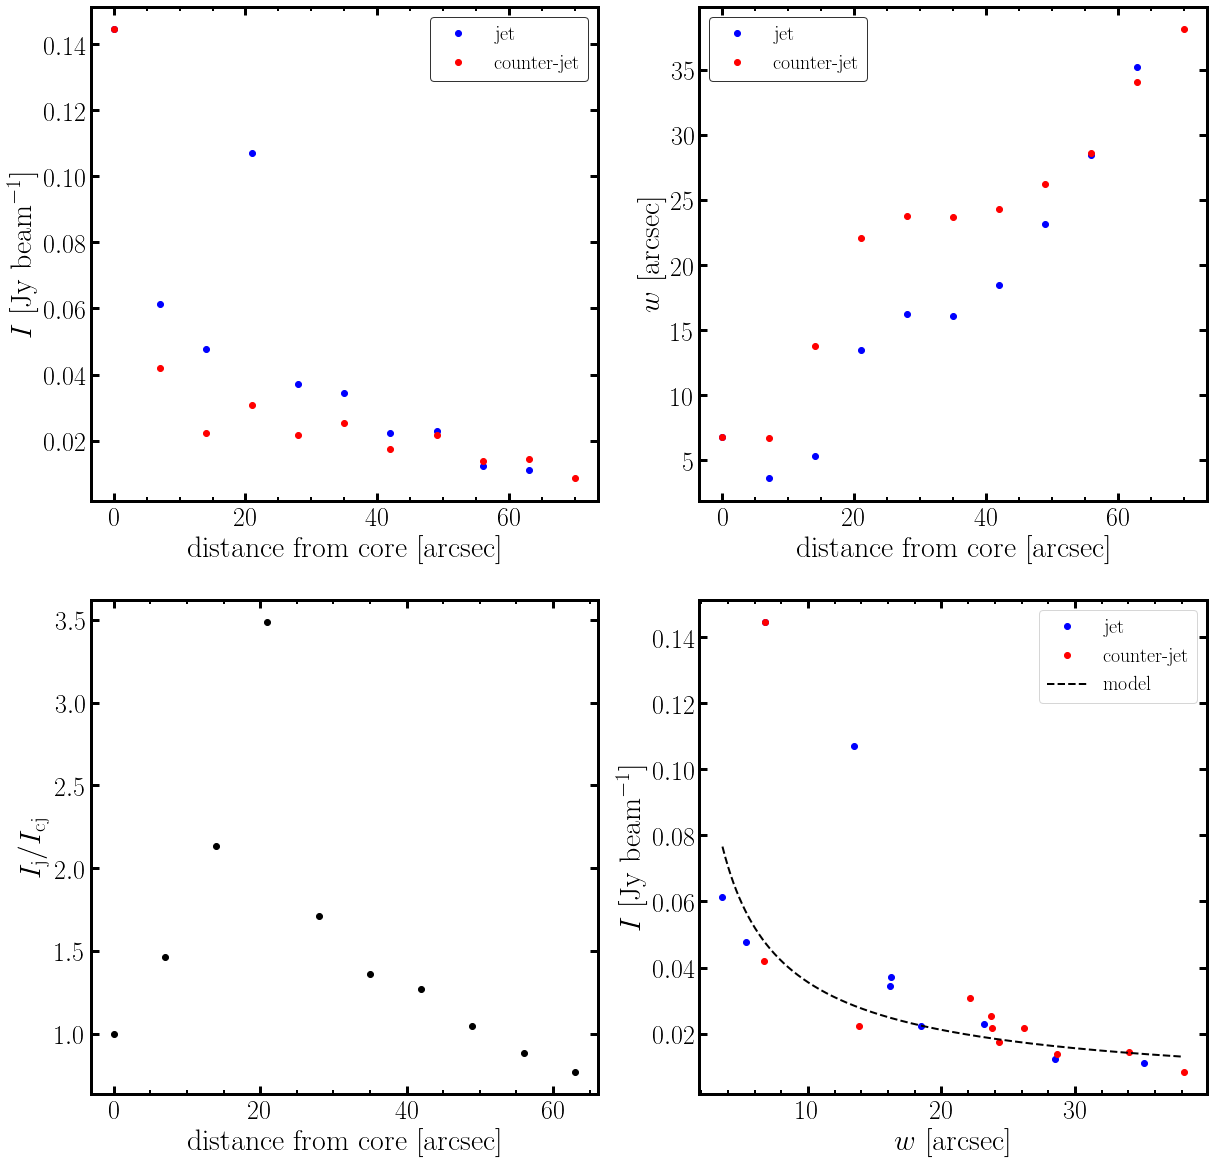

In [42]:

#inTable
table= ascii.read(outTables[0])
#table.remove_row(10)
b,c = splitter(table.columns[0])
tableCJ = table[0:len(b)+1]
tableCJrev = np.flip(tableCJ)

tableJ = table[len(b):]
tableJ.add_row(np.zeros(len(table.colnames))*np.nan)

widthCJ = tableCJrev['deconvolvedWidth']
widthJ = tableJ['deconvolvedWidth']

print np.nanmean(widthJ),np.nanmean(widthCJ)
widthRatio = np.divide(widthJ,widthCJ)

surfBrightCJ = tableCJrev['surfaceBrightness']
surfBrightJ = tableJ['surfaceBrightness']
print np.nanmean(surfBrightJ),np.nanmean(surfBrightCJ)

brightRatio = np.divide(surfBrightJ,surfBrightCJ)
cosAngle = np.divide(np.power(brightRatio,1./(2.+alpha)) - 1. , 1.+np.power(brightRatio,1./(2.+alpha)))/beta
angle = np.arccos(cosAngle)*180./np.pi

print 'Jets opening angle'

radius = [0,7,14,21,28,35,42,49,56,63,70]

outFig = figDir +'JetCJetAll1D.png'

bright = np.log10(table['surfaceBrightness'])
width = np.log10(table['deconvolvedWidth'])
m,b = np.polyfit(width, bright, 1) 

print 1./b
jCjPlot(radius,surfBrightJ,surfBrightCJ,widthJ,widthCJ,
        brightRatio,widthRatio,m,b,outFig)    

